# Introduction

In this project we will analyze a dataset that contains information about a credit card company’s clients. We will help the company segment customers into different groups in order to apply different business strategies for each type of customer.

Import the libraries and the data set

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cust = pd.read_csv('customer_segmentation.csv')

Print some basic summary stats on our dataframe

In [20]:
cust.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [21]:
cust.shape

(10127, 14)

In [22]:
cust.dtypes

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object

In [23]:
cust.isna().sum().sum()

0

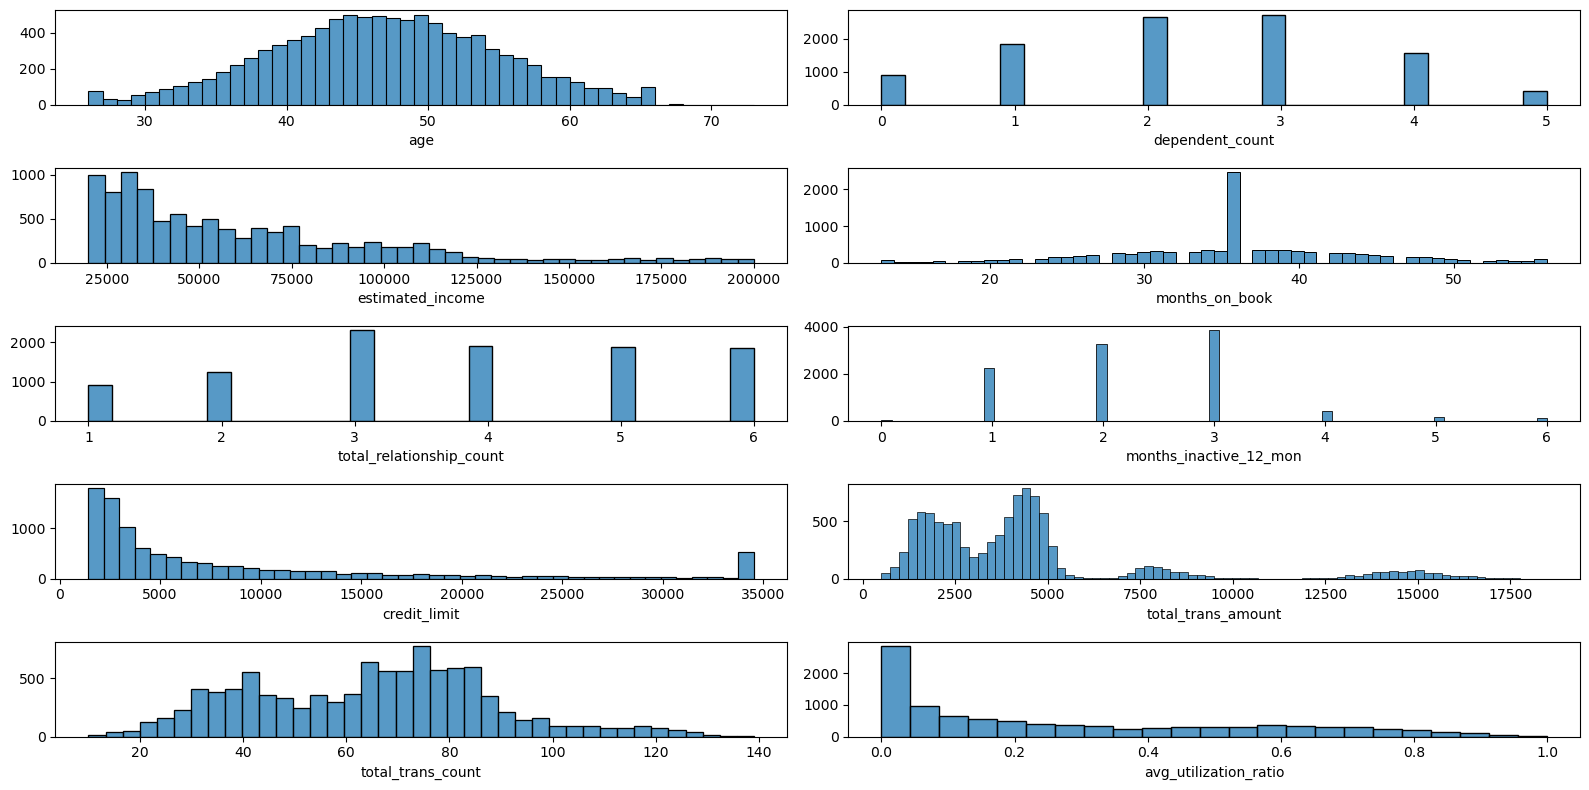

In [24]:
cust_numeric = cust.select_dtypes(include=np.number).drop(columns='customer_id')
fig, axs = plt.subplots(cust_numeric.shape[1]//2, 2, figsize=(16, 8))

for i, c in enumerate(cust_numeric.columns):
    g = sns.histplot(data=cust_numeric[c], ax=axs[i//2][i%2])
    g.set_ylabel('')

plt.tight_layout()
plt.show()

Some observations: Income is right-skewed, as we might expect. The credit limit might have a truncation issue around $34,000. The total transaction amounts seem to have four peaks.

Feature Engineering
========

In [25]:
cust_raw = cust.copy()

Categorical Variables
------------

In [26]:
cust.dtypes

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object

In [27]:
cust['gender'] = cust['gender'].map({'M': 1, 'F': 0})

cust['gender']

0        1
1        0
2        1
3        0
4        1
        ..
10122    1
10123    1
10124    0
10125    1
10126    0
Name: gender, Length: 10127, dtype: int64

In [28]:
cust['education_level'].unique()

array(['High School', 'Graduate', 'Uneducated', 'Post-Graduate',
       'College', 'Doctorate'], dtype=object)

In [29]:
education_levels = {'Uneducated' : 0, 'High School' : 1, 'College' : 2, 'Graduate' : 3, 'Post-Graduate' : 4, 'Doctorate' : 5}
cust['education_level'] = cust['education_level'].map(education_levels)
cust['education_level']

0        1
1        3
2        3
3        1
4        0
        ..
10122    3
10123    3
10124    1
10125    3
10126    3
Name: education_level, Length: 10127, dtype: int64

In [30]:
cust['marital_status'].unique()

array(['Married', 'Single', 'Unknown', 'Divorced'], dtype=object)

In [31]:
cust = pd.get_dummies(data = cust, columns = ['marital_status'])
cust.columns

Index(['customer_id', 'age', 'gender', 'dependent_count', 'education_level',
       'estimated_income', 'months_on_book', 'total_relationship_count',
       'months_inactive_12_mon', 'credit_limit', 'total_trans_amount',
       'total_trans_count', 'avg_utilization_ratio', 'marital_status_Divorced',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Unknown'],
      dtype='object')

Scale Variables
--------

In [32]:
cust_scaled = cust.copy()

In [33]:
scaler = StandardScaler()
cust_scaled = pd.DataFrame(scaler.fit_transform(cust_scaled))
cust_scaled.columns = cust.columns
cust_scaled = cust_scaled.drop(columns=['customer_id'])
cust_scaled

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,-0.282405,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.282405,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,-0.282405,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.282405,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,-0.282405,1.077338,-0.798507,-0.282609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,0.458314,1.059956,-0.266547,0.662787,-0.281380,0.509840,-0.522785,-0.337598,-0.509330,3.259358,2.221481,0.678714,-0.282405,-0.928214,1.252337,-0.282609
10123,-0.664382,1.059956,-0.266547,0.662787,-0.560775,-1.368442,0.120579,-0.337598,-0.479181,1.283475,0.176440,0.856458,3.541013,-0.928214,-0.798507,-0.282609
10124,-0.290150,-0.943436,-1.036462,-0.752211,-0.738571,0.008965,0.763943,0.651940,-0.354626,1.732994,-0.207005,-0.997155,-0.282405,1.077338,-0.798507,-0.282609
10125,-2.036565,1.059956,-0.266547,0.662787,-0.382978,0.008965,0.120579,0.651940,-0.368710,1.174848,-0.121795,-0.997155,-0.282405,-0.928214,-0.798507,3.538459


In [34]:
cust_scaled.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
age,10127.0,0.0,1.0,-3.0,-1.0,-0.0,1.0,3.0
gender,10127.0,0.0,1.0,-1.0,-1.0,-1.0,1.0,1.0
dependent_count,10127.0,0.0,1.0,-2.0,-1.0,-0.0,1.0,2.0
education_level,10127.0,0.0,1.0,-1.0,-1.0,-0.0,1.0,2.0
estimated_income,10127.0,0.0,1.0,-1.0,-1.0,-0.0,0.0,4.0
months_on_book,10127.0,-0.0,1.0,-3.0,-1.0,0.0,1.0,3.0
total_relationship_count,10127.0,0.0,1.0,-2.0,-1.0,0.0,1.0,1.0
months_inactive_12_mon,10127.0,-0.0,1.0,-2.0,-0.0,-0.0,1.0,4.0
credit_limit,10127.0,0.0,1.0,-1.0,-1.0,-0.0,0.0,3.0
total_trans_amount,10127.0,-0.0,1.0,-1.0,-1.0,-0.0,0.0,4.0


K Means Cluster Model
=============

Optimize Number of Clusters
-------------

In [35]:
inertias = []
for k in range(1,11):
    model = KMeans(n_clusters = k)
    model.fit_predict(cust_scaled)
    inertias.append(model.inertia_)
    
inertias

[162031.99999999997,
 144649.74481322523,
 132794.9882545705,
 122424.83551395856,
 111788.49746351992,
 103874.60795259947,
 98669.26092791461,
 94563.26053223074,
 91184.69949885637,
 88897.54410942047]

Text(0.5, 1.0, 'Elbow Plot')

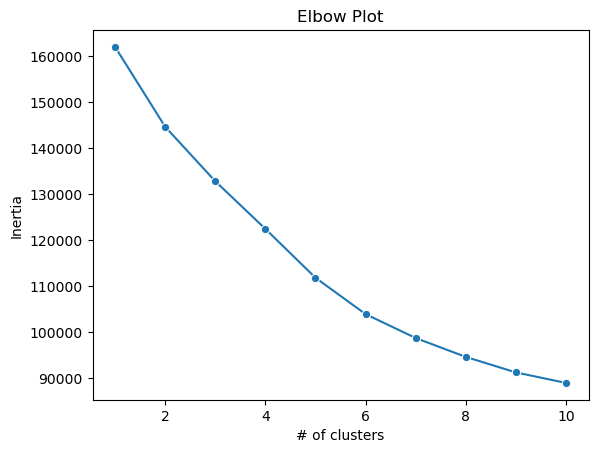

In [36]:
g = sns.lineplot(x=range(1,11), y=inertias, marker='o')
g.set_ylabel('Inertia')
g.set_xlabel('# of clusters')
g.set_title("Elbow Plot")

It looks like the optimal number of clusters is around 5 to 7. We'll try 6.

Fit Final Model
--------------

In [37]:
model = KMeans(n_clusters = 6)
model.fit_predict(cust_scaled)
print(model)

KMeans(n_clusters=6)


In [38]:
cust['cluster'] = model.labels_

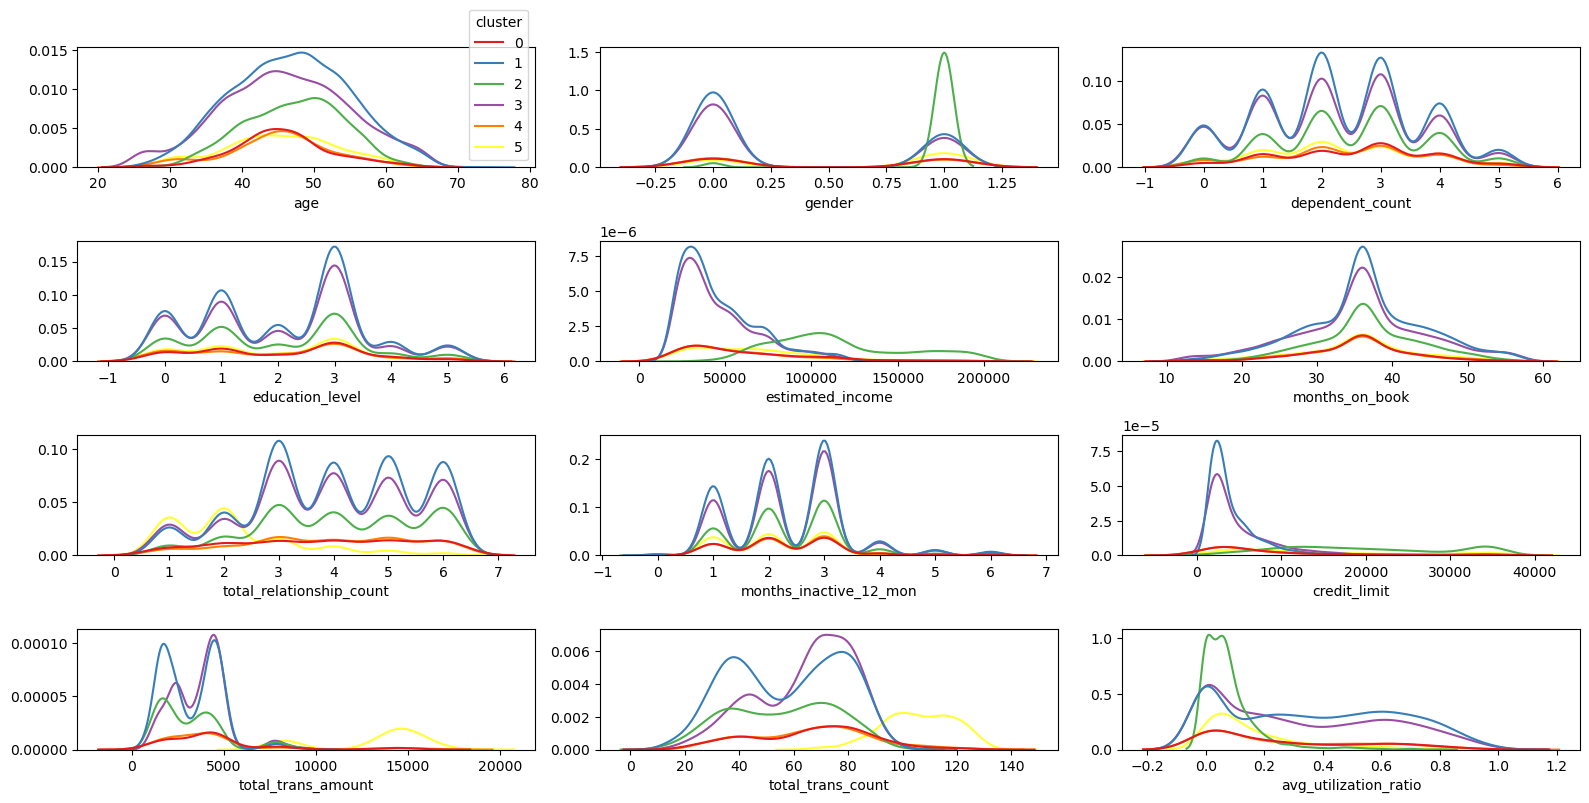

In [39]:
fig, axs = plt.subplots(4, 3, figsize=(16, 8))

for i, c in enumerate(['age', 'gender', 'dependent_count', 'education_level',
       'estimated_income', 'months_on_book', 'total_relationship_count',
       'months_inactive_12_mon', 'credit_limit', 'total_trans_amount',
       'total_trans_count', 'avg_utilization_ratio']):
    g = sns.kdeplot(data=cust, x=c, hue='cluster', palette='Set1', ax=axs[i//3][i%3], legend=True if i==0 else False)
    g.set_ylabel('')

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='age', ylabel='estimated_income'>

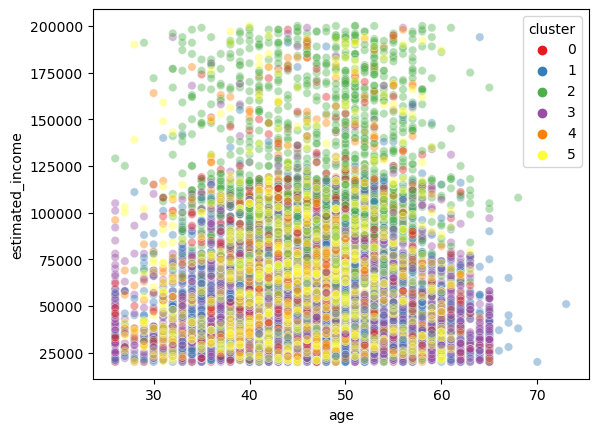

In [42]:
sns.scatterplot(data=cust, x='age', y='estimated_income', hue='cluster', alpha=.4, palette='Set1')

<AxesSubplot:xlabel='total_trans_amount', ylabel='total_trans_count'>

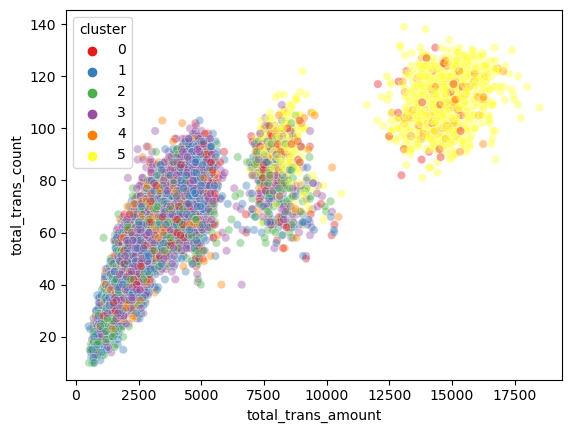

In [45]:
sns.scatterplot(data=cust, x='total_trans_amount', y='total_trans_count', hue='cluster', alpha=.4, palette='Set1')

<AxesSubplot:xlabel='months_on_book', ylabel='age'>

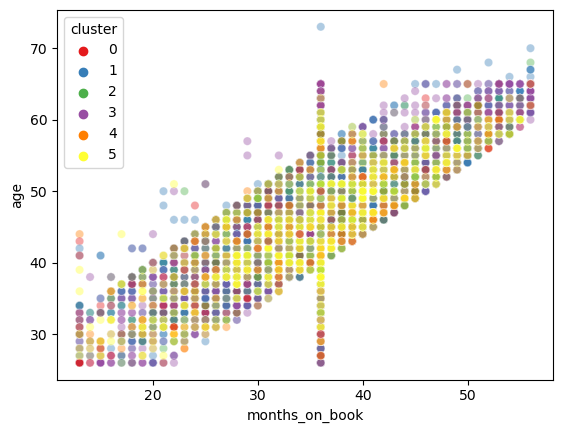

In [49]:
sns.scatterplot(data=cust, x='months_on_book', y='age', hue='cluster', alpha=.4, palette='Set1')

<AxesSubplot:xlabel='cluster'>

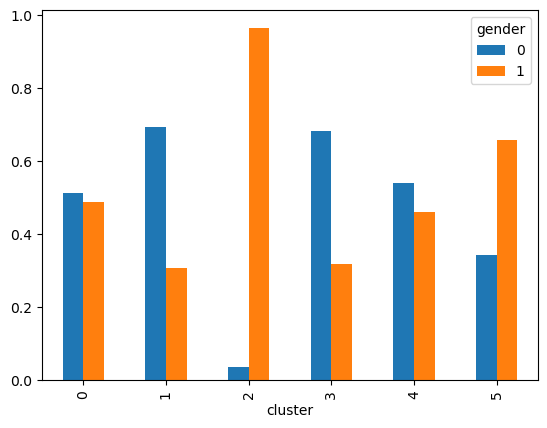

In [66]:
pd.crosstab(index=cust['cluster'], columns=cust['gender'], normalize='index').plot.bar()

<AxesSubplot:xlabel='cluster'>

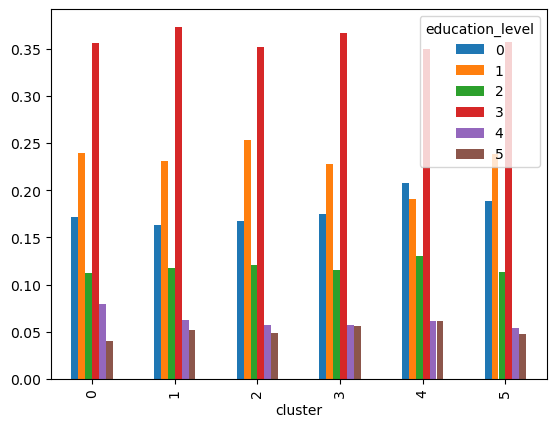

In [63]:
pd.crosstab(index=cust['cluster'], columns=cust['education_level'], normalize='index').plot.bar()

In [57]:
cust.dtypes

customer_id                   int64
age                           int64
gender                        int64
dependent_count               int64
education_level               int64
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
marital_status_Divorced       uint8
marital_status_Married        uint8
marital_status_Single         uint8
marital_status_Unknown        uint8
cluster                       int32
dtype: object